## Домашнее задание: Автокодировщик

## Цель:
### Разберемся с тем, как работает автокодировщик и что содержится в латентном представлении данных.

### Описание выполнения ДЗ:
- Обучить многослойный автокодировщик:
- отрисовать классы в латентном представлении автокодировщика с двумерным латентным слоем
- сделать tSNE над 32-мерным латентным слоем, отрисовать представление

### Обучить шумный автокодировщик:
- Добавить ко входным данным нормальный шум
- Сделать отражение части изображения
- Отрисовать карты активаций нейронов первого слоя

In [24]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
torch.utils.data.DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 32x32 colour images in 10 

Загрузка и подготовка данных

In [25]:
# Загрузка данных и создание dataloader
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataset = datasets.CIFAR10(root='./data', train=False,download=True,transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

Архитектура модели:

In [27]:

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Autoencoder, self).__init__()
        
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        # Создание скрытого представления
        self.latent = nn.Linear(128*4*4, latent_dim)
        
        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (128,4,4)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        z = self.latent(x)
        x = self.decoder(z)
        return x, z

Обучение модели

In [28]:
# Определение модели
model = Autoencoder(latent_dim=2).to(device)

In [33]:
# Обучение

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(10):
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon, z = model(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.03579942509531975
Epoch 2, Loss: 0.03923672065138817
Epoch 3, Loss: 0.03881338611245155
Epoch 4, Loss: 0.03827817365527153
Epoch 5, Loss: 0.03508675843477249
Epoch 6, Loss: 0.035471949726343155
Epoch 7, Loss: 0.032808028161525726
Epoch 8, Loss: 0.0360800139605999
Epoch 9, Loss: 0.03703193739056587
Epoch 10, Loss: 0.03980748727917671


Визуализация латентного пространства

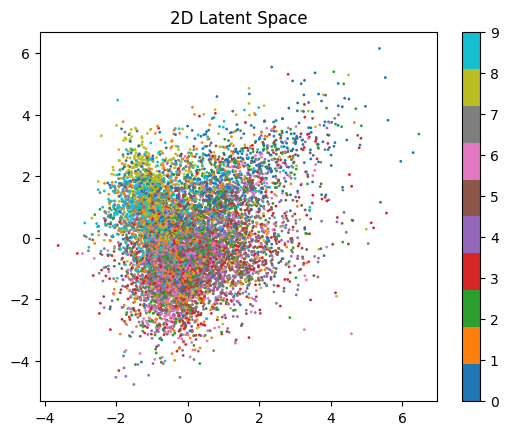

In [65]:
model.eval()
all_z = []
all_labels = []
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        recon, z = model(data)
        all_z.append(z.cpu())
        all_labels.append(labels)
all_z = torch.cat(all_z).numpy()
all_labels = torch.cat(all_labels).numpy()

plt.scatter(all_z[:,0], all_z[:,1], c=all_labels, cmap='tab10', s=1)
plt.colorbar()
plt.title('2D Latent Space')
plt.show()

In [56]:
def reconstructions(model, test_loader, n=10):
    model.eval()
    with torch.no_grad():  # Отключаем вычисление градиентов
        data, _ = next(iter(test_loader))
        # Реконструкция
        recon, _ = model(data)
        
    # Создаем график
    fig, axes = plt.subplots(2, n, figsize=(20, 4))
    plt.suptitle('Исходное vs Востановленное', fontsize=16)
    
    for i in range(n):
        # Исходное изображения
        img = data[i].cpu().permute(1, 2, 0).numpy()
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        
        # Восстановленные изображения
        rec = recon[i].cpu().permute(1, 2, 0).numpy()
        axes[1, i].imshow(rec)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

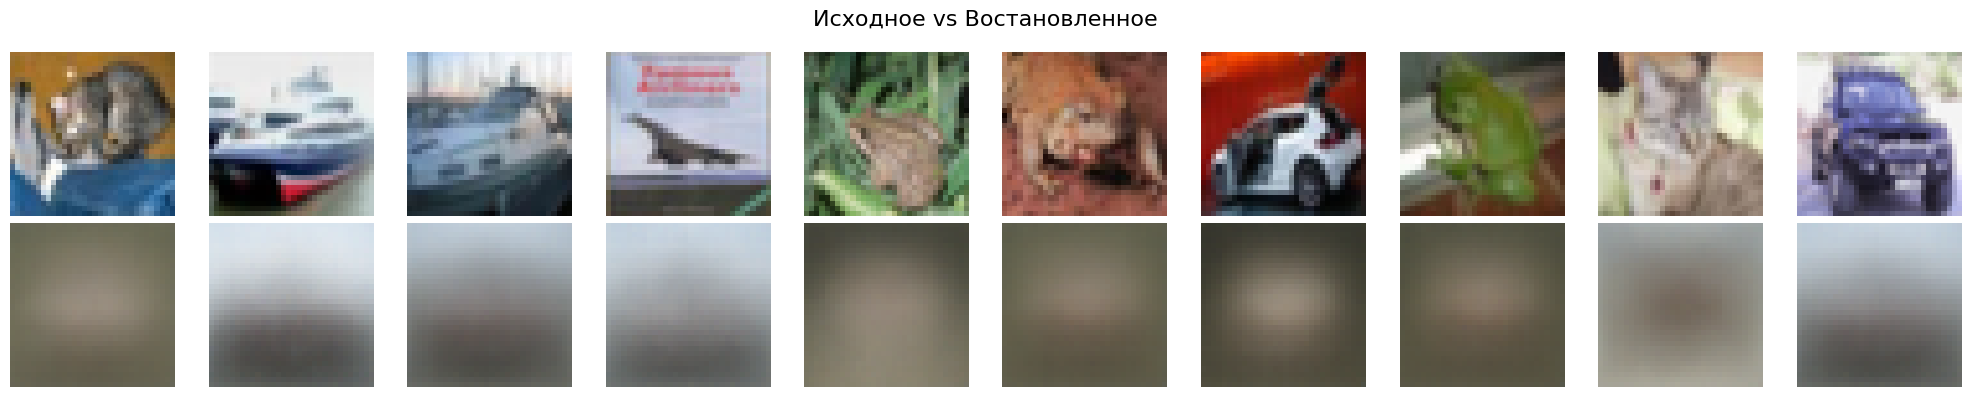

In [64]:
reconstructions(model, test_loader, n=10)

t-SNE для 32-мерного латентного пространства

Обучение автокодировщика с latent_dim=32:

In [66]:
model_32 = Autoencoder(latent_dim=32).to(device)
optimizer = torch.optim.Adam(model_32.parameters(), lr=0.001)

for epoch in range(10):
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon, z = model_32(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.02111724764108658
Epoch 2, Loss: 0.016757547855377197
Epoch 3, Loss: 0.014430353417992592
Epoch 4, Loss: 0.013495082035660744
Epoch 5, Loss: 0.013851604424417019
Epoch 6, Loss: 0.011476964689791203
Epoch 7, Loss: 0.012946812435984612
Epoch 8, Loss: 0.013170179910957813
Epoch 9, Loss: 0.011140149086713791
Epoch 10, Loss: 0.011635953560471535


Применение t-SNE:

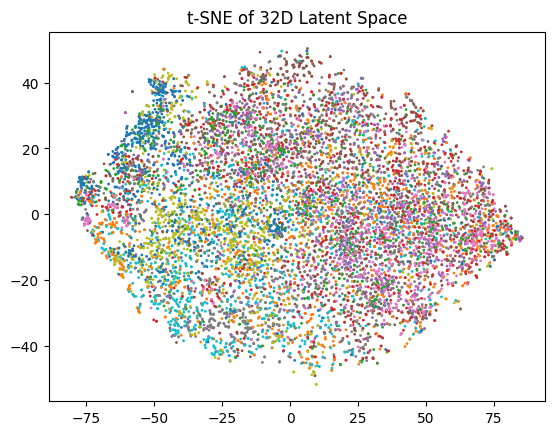

In [20]:
model_32.eval()
all_z_32 = []
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon, z = model_32(data)
        all_z_32.append(z.cpu())
all_z_32 = torch.cat(all_z_32).numpy()

tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(all_z_32)

plt.scatter(z_2d[:,0], z_2d[:,1], c=all_labels, cmap='tab10', s=1)
plt.title('t-SNE of 32D Latent Space')
plt.show()

Шумной автокодировщик с отражением

Создание зашумленного датасета

In [ ]:
class NoisyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, noise_std=0.2, flip_prob=0.5):
        self.dataset = dataset
        self.noise_std = noise_std
        self.flip_prob = flip_prob

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        # Добавление шума
        noisy_image = image + self.noise_std * torch.randn_like(image)
        # Горизонтальное отражение
        if torch.rand(1) < self.flip_prob:
            noisy_image = torch.flip(noisy_image, dims=[2])
        return noisy_image, image

noisy_train_dataset = NoisyDataset(train_dataset, noise_std=0.2, flip_prob=0.5)
noisy_train_loader = torch.utils.data.DataLoader(noisy_train_dataset, batch_size=256, shuffle=True)

Обучение шумного автокодировщика:

In [ ]:
model_noisy = Autoencoder(latent_dim=2).to(device)
optimizer = torch.optim.Adam(model_noisy.parameters(), lr=0.001)

for epoch in range(10):
    for noisy_data, clean_data in noisy_train_loader:
        noisy_data = noisy_data.to(device)
        clean_data = clean_data.to(device)
        optimizer.zero_grad()
        recon, z = model_noisy(noisy_data)
        loss = criterion(recon, clean_data)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Визуализация карт активаций

In [ ]:
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

activation = {}
model_noisy.encoder[0].register_forward_hook(get_activation('conv1'))

data, _ = test_dataset[0]
data = data.unsqueeze(0).to(device)
model_noisy(data)
act = activation['conv1'].squeeze(0)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    if i < act.shape[0]:
        ax.imshow(act[i].cpu(), cmap='gray')
        ax.axis('off')
plt.suptitle('Activation Maps of First Layer')
plt.show()